<a href="https://colab.research.google.com/github/andreeadeac22/IFT6760H20/blob/master/Assignment2_Template_Part_1_IFT6760C_H20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import jax
import jax.numpy as np
from jax import random
from jax import jit, grad
from jax.config import config
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200

config.update("jax_enable_x64", True)

# Bias in Policy Gradients

The goal of this exercise is to understand the different sources of bias that we often encounted in practice when working under the infinite horizon setting. To verify this empirically, we will compare our derivative estimator with the exact policy gradient obtained by automatic differentiation. 

As in the last assignment, we use the simple polytope problem:

In [2]:
def dadashi_fig2d():
  P = np.array([[[0.7, 0.3], [0.2, 0.8]],
                [[0.99, 0.01], [0.99, 0.01]]])
  R = np.array(([[-0.45, -0.1],
                  [0.5,  0.5]]))
  return P, R, 0.9

transition, reward, discount = dadashi_fig2d()
nstates, nactions = reward.shape

initial_distribution = np.ones(nstates)/nstates

/usr/local/lib/python3.6/dist-packages/jax/lib/xla_bridge.py:123: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In the discounted setting, the effective horizon is about:

In [3]:
effective_horizon = 1/(1 - discount)
print(f"{effective_horizon} steps")

10.000000000000002 steps


which gives you a sense of how large to set $T$ (but generally speaking this depends on the mixing time of your chain).

Note that in this exercise, we parameterize the policy by just taking [jax.nn.softmax](https://jax.readthedocs.io/en/test-docs/_autosummary/jax.nn.softmax.html) over a matrix of $\mathcal{S} \times \mathcal{A}$ parameters.

In [0]:
def boltzmann_policy(params):
  return jax.nn.softmax(params)

Now a heads up: the random number generator of JAX [works differently](https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#%F0%9F%94%AA-Random-Numbers) than that of Numpy. Everytime that you want to get *fresh* new random samples, you need to *split* a key, pass the subkey to the sampling function, and propagate the main key around in your code. 

To simplify sampling from a categorical distribution, a wrote the following function ``sample_categorical``. Now bear in mind that everytime that you call this function, you need to collect the new key as its first argument, and pass it back the next time you call it.

Also, <font color='red'>it's quite slow</font>: JAX would do better in a non-sequential setting. There are probably better ways to do this. Feel free to improve.

In [0]:
def sample_categorical(key, p):
  key, subkey = random.split(key)
  return key, random.categorical(subkey, np.log(p))

Equipped with this function, we can now sample an infinite trajectory given an MDP and a policy. The following function implements this idea using a generator which yields state-action pairs only.

In [0]:
def sample_trajectory(key, transition, policy, initial_distribution):
  key, state = sample_categorical(key, initial_distribution)
  while True:
    key, action = sample_categorical(key, policy[state, :])
    yield np.asarray((state, action))
    key, state = sample_categorical(key, transition[action, state, :])

You can also use this helper function which consumes ``nsamples`` from the given generator and stack its output into an array.

In [0]:
def take_samples(generator, nsamples):
  return np.vstack([sample for _, sample in zip(range(nsamples), generator)])

In this exercise, we are going to assess the bias introduced by estimating a REINFORCE-type (SF) gradient under the undiscounted distribution over trajectories. The biased estimator that we are going to implement stems from the expectation: 
\begin{align*}
\mathbb{E}\left[\sum_{t=0}^\infty \gamma^t \nabla_\theta \log \pi_\theta(A_t |S_t) \left(\sum_{k=t}^\infty \gamma^{k-t} r(S_k, A_k) \right)\right] \enspace .
\end{align*}

Some caveats:
1. We would need an infinite trajectory: truncation is needed in practice
2. The expression within the outer summation over $t$ must be discounted, but in practice this is often neglected/forgotten.

We are going to assess this bias in practice. First, we need a function to compute a sum of discounted rewards. This could be achieved with a for-loop in pure python but it would be slow and we wouldn't be able to jit the resulting code. I'm providing you with my implementation which uses a convolution to compute the discounted returns. To see this, note that the return at time $i$ is of the form:
\begin{align*}
g_i \equiv \sum_{t=0}^T \gamma^t r_{t+i} \enspace, 
\end{align*}
which is a [discrete cross-correlation](https://en.wikipedia.org/wiki/Cross-correlation). The cross-correlation is related to the convolution by inverting the time index. Because jax currently doesn't implement [numpy.convolve](https://docs.scipy.org/doc/numpy/reference/generated/numpy.convolve.html), we have to use the rather complicated [jax.lax.conv_general_dilated](https://jax.readthedocs.io/en/test-docs/_autosummary/jax.lax.conv_general_dilated.html#jax.lax.conv_general_dilated).


In [0]:
def convolve1D(x, y):
  # Based on https://github.com/google/jax/issues/1561
  x_jax = np.reshape(x,(1,1,len(x)))
  y_jax = np.flip(np.reshape(y,(1,1,len(y))),2)
  return np.ravel(jax.lax.conv_general_dilated(x_jax,y_jax,[1],[(len(x)-1,len(x)-1)]))

def discount_filter(rewards, discount):
  nsamples = rewards.shape[0]
  discount_sequence = np.power(discount, np.arange(nsamples))
  filtered_rewards = convolve1D(rewards[::-1], discount_sequence)
  return filtered_rewards[:nsamples][::-1]


To compare with the true gradient, it suffices to code-up the true objective and let JAX differentiation through it. I'm giving you my implementation of the 
direct policy evaluation code from the last assignment:


In [0]:
def direct_policy_evaluation(P, R, discount, policy):
  ppi = np.einsum('ast,sa->st', P, policy)
  rpi = np.einsum('sa,sa->s', R, policy)
  vf = np.linalg.solve(np.eye(P.shape[-1]) - discount*ppi, rpi)
  return vf

We will be measuring the error in the policy gradient in terms of both the direction and magnitude. The angle between two vector can be obtained from:
\begin{align*}
u^\top v = \| u \| \| v\| \cos(\theta) ,
\end{align*}
where $\theta$ is the angle between the vectors. Therefore, we can solve for that angle with: 
\begin{align*}
\theta = \text{acos}\left(\frac{u^\top v}{\|u \| \|v\|}\right) \enspace .
\end{align*}

In [0]:
def angle_vectors(u, v):
  return np.arccos(np.dot(u, v)/(np.linalg.norm(u)*np.linalg.norm(v)))

Finally, we are also interested in assessing the relative error in the gradients in terms of magnitude:

In [0]:
def relative_error(u, v):
  return np.linalg.norm(u - v)/np.linalg.norm(v)

# Questions

Implement a "surrogate loss" to obtain a truncated REINFORCE estimator. 
That is: a function which upon automatic differentiation by JAX will give you the right derivative estimator.

In [0]:
def make_truncated_reinforce(discount):
  def trajectory_wise_surrogate_loss(params, data, discounted_returns):
    """ Surrogate loss for a REINFORCE-type derivative estimator
    Args:
      params (ndarray): Array of S x A parameters
      data (ndarray): Array of nsamples x 2 where the first column are states
        and the second column are actions
      discounted_returns (ndarray): Array of nsamples x 1 containing the sum of
        discounted rewards for each corresponding sample from ``data``
    Returns:
      A scalar which is the mean return-weighted log probabilities
    """
    # ADD YOUR CODE HERE
    log_pi = np.log(params[data[:,0], data[:,1]])
    log_ret = np.multiply(log_pi, discounted_returns)
    gamma_log_ret = discount_filter(log_ret, discount)
    return gamma_log_ret[0]
  return trajectory_wise_surrogate_loss

Using the provided policy evaluation code, implement the exact performance measure which we will then use to compute the true gradient by AD. That is, compute:
\begin{align*}
J(\theta) \equiv \alpha^\top(I - \gamma P_\pi)^{-1} r_\pi \enspace.
\end{align*}

In [0]:
def make_performance_measure(P, R, discount, initial_distribution):
  def objective(params):
    """ Compute the expected discounted return for the given Boltzmann policy
      Args:
          params (ndarray): Array of S x A parameters for the
            Boltzmann policy
      Returns:
        A scalar representing the expected discounted return
    """
    # ADD YOUR CODE HERE
    vf = direct_policy_evaluation(P, R, discount, params)
    return np.matmul(initial_distribution, vf)
  return objective

We can now create gradient functions for the corresponding "losses":

In [0]:
true_gradient = jit(grad(make_performance_measure(transition, reward, discount, initial_distribution)))
truncated_gradient = jit(grad(make_truncated_reinforce(discount)))
truncated_gradient_no_discount = jit(grad(make_truncated_reinforce(1.0)))

Vary the parameters ``nruns`` and ``trajectory_len`` below to collect trajectories of varying length. Using a random policy (code provided), compare: 

1. A truncated REINFORCE estimator with $T < \infty$ but where you use the exact Q-values (pre-computed using ``direct_policy_evaluation``) in: 
\begin{align*}
\mathbb{E}\left[\sum_{t=0}^T \gamma^t \nabla_\theta \log \pi_\theta(A_t |S_t) Q_{\pi, \gamma}(S_t, A_t)\right] \enspace .
\end{align*}
  1.1 Without discounting before the gradient term (but discounted Q-values):
  \begin{align*}
\mathbb{E}\left[\sum_{t=0}^T \nabla_\theta \log \pi_\theta(A_t |S_t) Q_{\pi, \gamma}(S_t, A_t)\right] \enspace .
\end{align*}
2. A truncated REINFORCE estimator  with $T < \infty$ and sampled returns (from the same trajectory):
\begin{align*}
\mathbb{E}\left[\sum_{t=0}^T \gamma^t \nabla_\theta \log \pi_\theta(A_t |S_t) \left(\sum_{k=t}^\infty \gamma^{k-t} r(S_k, A_k) \right)\right] \enspace .
\end{align*}
  2.1 Without discounting before the gradient term:
  \begin{align*}
\mathbb{E}\left[\sum_{t=0}^T \nabla_\theta \log \pi_\theta(A_t |S_t) \left(\sum_{k=t}^\infty \gamma^{k-t} r(S_k, A_k) \right)\right] \enspace .
\end{align*}

In [0]:
nruns = 100
trajectory_len = 10

key = random.PRNGKey(0)
key, subkey = random.split(key)
random_params = random.uniform(key, reward.shape)

policy = boltzmann_policy(random_params)

# Compute the Q function here (can be re-used across all runs)
# ADD YOU CODE HERE (two lines)

vf = direct_policy_evaluation(transition, reward, discount, policy)
pv = np.einsum('ijk,k->ji', transition, vf)
qf = reward + discount * pv

bias_grads1 = []
bias_grads11 = []
bias_grads2 = []
bias_grads21 = []
for i in range(nruns):
  key, subkey = random.split(key)
  data = take_samples(sample_trajectory(key, transition, policy, initial_distribution), trajectory_len)
  rewards = reward[data[:, 0], data[:, 1]]
  filtered = discount_filter(reward[data[:, 0], data[:, 1]], discount)
  bg1 = truncated_gradient(random_params, data, qf[data[:, 0], data[:, 1]]) 
  bg11 = truncated_gradient_no_discount(random_params, data, qf[data[:, 0], data[:, 1]])
  bg2 = truncated_gradient(random_params, data, filtered)
  bg21 = truncated_gradient_no_discount(random_params, data, filtered)

  bias_grads1.append(bg1.ravel())
  bias_grads11.append(bg11.ravel())
  bias_grads2.append(bg2.ravel())
  bias_grads21.append(bg21.ravel())

In [16]:
import seaborn as sns
sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


For each estimator, plot each of the ``nruns`` stochastic gradient as a point of a polar scatter plot. The angle of each point represents the angular error and the distance from the center is the error in the magnitude. For an unbiased estimator, the points should concentrate around the center.

Trajectory length  10
Mean angular error 58.16 degrees
Mean angular error 57.32 degrees
Mean angular error 70.99 degrees
Mean angular error 70.04 degrees


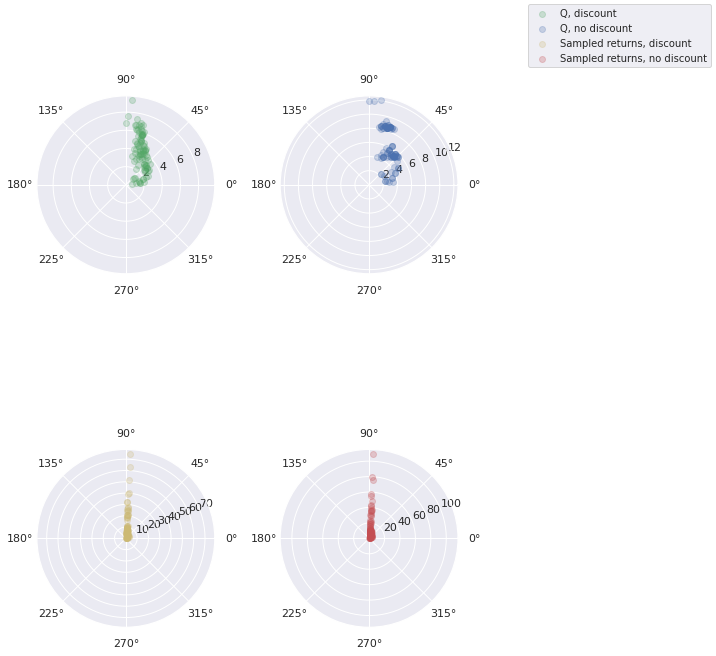

In [17]:
tg = true_gradient(random_params).ravel()

fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(231, projection='polar')
ax2 = fig.add_subplot(232, projection='polar')
ax3 = fig.add_subplot(234, projection='polar')
ax4 = fig.add_subplot(235, projection='polar')

errors1 = np.vstack([np.asarray((angle_vectors(bg1, tg), relative_error(bg1, tg))) for bg1 in bias_grads1])
errors11 = np.vstack([np.asarray((angle_vectors(bg11, tg), relative_error(bg11, tg))) for bg11 in bias_grads11])
errors2 = np.vstack([np.asarray((angle_vectors(bg2, tg), relative_error(bg2, tg))) for bg2 in bias_grads2])
errors21 = np.vstack([np.asarray((angle_vectors(bg21, tg), relative_error(bg21, tg))) for bg21 in bias_grads21])


mean_error1 = np.mean(errors1, axis=0)
mean_error11 = np.mean(errors11, axis=0)
mean_error2 = np.mean(errors2, axis=0)
mean_error21 = np.mean(errors21, axis=0)


print("Trajectory length ", trajectory_len)
print('Mean angular error {:0.2f} degrees'.format(np.degrees(mean_error1[0])))
print('Mean angular error {:0.2f} degrees'.format(np.degrees(mean_error11[0])))
print('Mean angular error {:0.2f} degrees'.format(np.degrees(mean_error2[0])))
print('Mean angular error {:0.2f} degrees'.format(np.degrees(mean_error21[0])))

fig.tight_layout()

ax1.scatter(errors1[:,0], errors1[:,1], alpha=0.25, c='g', label="Q, discount")
ax2.scatter(errors11[:,0], errors11[:,1], alpha=0.25, c='b', label="Q, no discount")
ax3.scatter(errors2[:,0], errors2[:,1], alpha=0.25, c='y', label="Sampled returns, discount")
ax4.scatter(errors21[:,0], errors21[:,1], alpha=0.25, c='r', label="Sampled returns, no discount")

handles, labels = [(a + b + c + d) for a, b, c, d in zip(ax1.get_legend_handles_labels(), ax2.get_legend_handles_labels(), ax3.get_legend_handles_labels(), ax4.get_legend_handles_labels())]
fig.legend(handles, labels, loc='upper right', prop={'size': 10})

In [0]:
nruns = 100
trajectory_len = 100

key = random.PRNGKey(0)
key, subkey = random.split(key)
random_params = random.uniform(key, reward.shape)

policy = boltzmann_policy(random_params)

# Compute the Q function here (can be re-used across all runs)
# ADD YOU CODE HERE (two lines)

vf = direct_policy_evaluation(transition, reward, discount, policy)
pv = np.einsum('ijk,k->ji', transition, vf)
qf = reward + discount * pv

bias_grads1 = []
bias_grads11 = []
bias_grads2 = []
bias_grads21 = []
for i in range(nruns):
  key, subkey = random.split(key)
  data = take_samples(sample_trajectory(key, transition, policy, initial_distribution), trajectory_len)
  rewards = reward[data[:, 0], data[:, 1]]
  filtered = discount_filter(reward[data[:, 0], data[:, 1]], discount)
  bg1 = truncated_gradient(random_params, data, qf[data[:, 0], data[:, 1]]) 
  bg11 = truncated_gradient_no_discount(random_params, data, qf[data[:, 0], data[:, 1]])
  bg2 = truncated_gradient(random_params, data, filtered)
  bg21 = truncated_gradient_no_discount(random_params, data, filtered)

  bias_grads1.append(bg1.ravel())
  bias_grads11.append(bg11.ravel())
  bias_grads2.append(bg2.ravel())
  bias_grads21.append(bg21.ravel())

Trajectory length  100
Mean angular error 57.91 degrees
Mean angular error 57.50 degrees
Mean angular error 73.26 degrees
Mean angular error 61.04 degrees


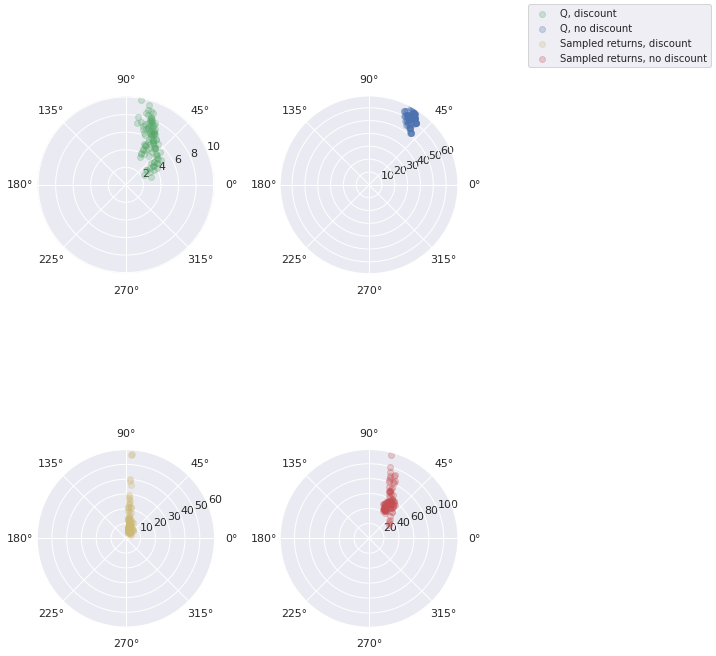

In [19]:
tg = true_gradient(random_params).ravel()

fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(231, projection='polar')
ax2 = fig.add_subplot(232, projection='polar')
ax3 = fig.add_subplot(234, projection='polar')
ax4 = fig.add_subplot(235, projection='polar')

errors1 = np.vstack([np.asarray((angle_vectors(bg1, tg), relative_error(bg1, tg))) for bg1 in bias_grads1])
errors11 = np.vstack([np.asarray((angle_vectors(bg11, tg), relative_error(bg11, tg))) for bg11 in bias_grads11])
errors2 = np.vstack([np.asarray((angle_vectors(bg2, tg), relative_error(bg2, tg))) for bg2 in bias_grads2])
errors21 = np.vstack([np.asarray((angle_vectors(bg21, tg), relative_error(bg21, tg))) for bg21 in bias_grads21])


mean_error1 = np.mean(errors1, axis=0)
mean_error11 = np.mean(errors11, axis=0)
mean_error2 = np.mean(errors2, axis=0)
mean_error21 = np.mean(errors21, axis=0)

print("Trajectory length ", trajectory_len)
print('Mean angular error {:0.2f} degrees'.format(np.degrees(mean_error1[0])))
print('Mean angular error {:0.2f} degrees'.format(np.degrees(mean_error11[0])))
print('Mean angular error {:0.2f} degrees'.format(np.degrees(mean_error2[0])))
print('Mean angular error {:0.2f} degrees'.format(np.degrees(mean_error21[0])))

fig.tight_layout()

ax1.scatter(errors1[:,0], errors1[:,1], alpha=0.25, c='g', label="Q, discount")
ax2.scatter(errors11[:,0], errors11[:,1], alpha=0.25, c='b', label="Q, no discount")
ax3.scatter(errors2[:,0], errors2[:,1], alpha=0.25, c='y', label="Sampled returns, discount")
ax4.scatter(errors21[:,0], errors21[:,1], alpha=0.25, c='r', label="Sampled returns, no discount")

handles, labels = [(a + b + c + d) for a, b, c, d in zip(ax1.get_legend_handles_labels(), ax2.get_legend_handles_labels(), ax3.get_legend_handles_labels(), ax4.get_legend_handles_labels())]
fig.legend(handles, labels, loc='upper right', prop={'size': 10})

In [0]:
nruns = 100
trajectory_len = 1000

key = random.PRNGKey(0)
key, subkey = random.split(key)
random_params = random.uniform(key, reward.shape)

policy = boltzmann_policy(random_params)

# Compute the Q function here (can be re-used across all runs)
# ADD YOU CODE HERE (two lines)

vf = direct_policy_evaluation(transition, reward, discount, policy)
pv = np.einsum('ijk,k->ji', transition, vf)
qf = reward + discount * pv

bias_grads1 = []
bias_grads11 = []
bias_grads2 = []
bias_grads21 = []
for i in range(nruns):
  key, subkey = random.split(key)
  data = take_samples(sample_trajectory(key, transition, policy, initial_distribution), trajectory_len)
  rewards = reward[data[:, 0], data[:, 1]]
  filtered = discount_filter(reward[data[:, 0], data[:, 1]], discount)
  bg1 = truncated_gradient(random_params, data, qf[data[:, 0], data[:, 1]]) 
  bg11 = truncated_gradient_no_discount(random_params, data, qf[data[:, 0], data[:, 1]])
  bg2 = truncated_gradient(random_params, data, filtered)
  bg21 = truncated_gradient_no_discount(random_params, data, filtered)

  bias_grads1.append(bg1.ravel())
  bias_grads11.append(bg11.ravel())
  bias_grads2.append(bg2.ravel())
  bias_grads21.append(bg21.ravel())

Trajectory length  1000
Mean angular error 57.91 degrees
Mean angular error 54.57 degrees
Mean angular error 73.26 degrees
Mean angular error 55.65 degrees


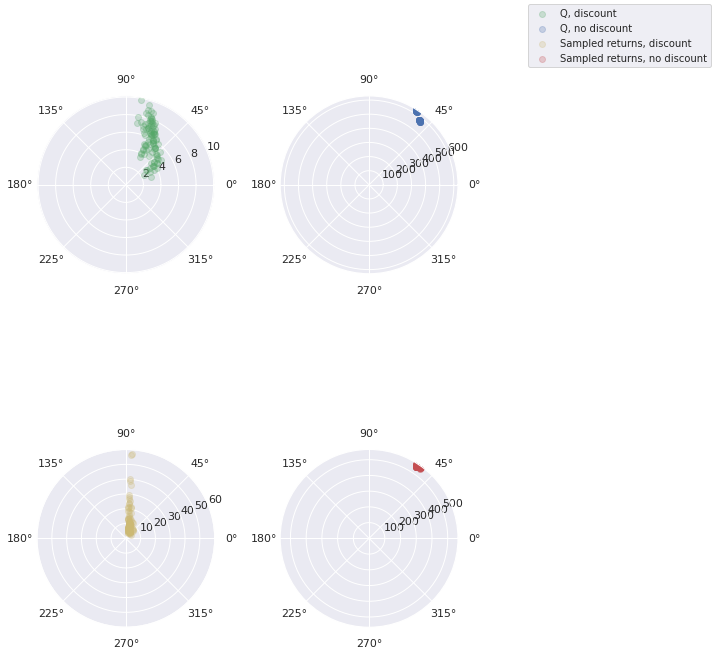

In [21]:
tg = true_gradient(random_params).ravel()

fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(231, projection='polar')
ax2 = fig.add_subplot(232, projection='polar')
ax3 = fig.add_subplot(234, projection='polar')
ax4 = fig.add_subplot(235, projection='polar')

errors1 = np.vstack([np.asarray((angle_vectors(bg1, tg), relative_error(bg1, tg))) for bg1 in bias_grads1])
errors11 = np.vstack([np.asarray((angle_vectors(bg11, tg), relative_error(bg11, tg))) for bg11 in bias_grads11])
errors2 = np.vstack([np.asarray((angle_vectors(bg2, tg), relative_error(bg2, tg))) for bg2 in bias_grads2])
errors21 = np.vstack([np.asarray((angle_vectors(bg21, tg), relative_error(bg21, tg))) for bg21 in bias_grads21])


mean_error1 = np.mean(errors1, axis=0)
mean_error11 = np.mean(errors11, axis=0)
mean_error2 = np.mean(errors2, axis=0)
mean_error21 = np.mean(errors21, axis=0)

print("Trajectory length ", trajectory_len)
print('Mean angular error {:0.2f} degrees'.format(np.degrees(mean_error1[0])))
print('Mean angular error {:0.2f} degrees'.format(np.degrees(mean_error11[0])))
print('Mean angular error {:0.2f} degrees'.format(np.degrees(mean_error2[0])))
print('Mean angular error {:0.2f} degrees'.format(np.degrees(mean_error21[0])))

fig.tight_layout()

ax1.scatter(errors1[:,0], errors1[:,1], alpha=0.25, c='g', label="Q, discount")
ax2.scatter(errors11[:,0], errors11[:,1], alpha=0.25, c='b', label="Q, no discount")
ax3.scatter(errors2[:,0], errors2[:,1], alpha=0.25, c='y', label="Sampled returns, discount")
ax4.scatter(errors21[:,0], errors21[:,1], alpha=0.25, c='r', label="Sampled returns, no discount")

handles, labels = [(a + b + c + d) for a, b, c, d in zip(ax1.get_legend_handles_labels(), ax2.get_legend_handles_labels(), ax3.get_legend_handles_labels(), ax4.get_legend_handles_labels())]
fig.legend(handles, labels, loc='upper right', prop={'size': 10})